## Generacion de Datos Historicos Coomproriente


In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd

# Leer todas las hojas
sheets = pd.read_excel('../Datos_Precios/Lista de precios coomproriente.xlsx', sheet_name=None)

# Combinar todas las hojas en un solo DataFrame, agregando el nombre de la hoja como columna
df_all = pd.concat(
    [df.assign(PRODUCTO=sheet_name) for sheet_name, df in sheets.items()],
    ignore_index=True
)

df_all.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   PRODUCTO  1240 non-null   object        
 1   PRECIO    1240 non-null   object        
 2   CANTIDAD  1240 non-null   object        
 3   FECHA     1240 non-null   datetime64[ns]
 4   ORIGEN    1240 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 48.6+ KB


In [3]:
df_all['PRODUCTO'].unique()

array(['Aguacate papelillo', 'Ajo', 'Arracacha Amarilla',
       'Arveja Verde En Vaina', 'Banano Urabá', 'Cebolla Cabezona Blanca',
       'Cebolla Cabezona Roja', 'Cebolla Larga', 'Cilantro',
       'Durazno Nacional', 'Espinaca', 'Feijoba', 'Fresa', 'Frijol Verde',
       'Guanabana', 'Guayaba', 'Habichuela', 'Huevos AA', 'Huevos Aaa',
       'Lechuga Crespa Verde', 'Limon Mandarino', 'Limon Tahití', 'Lulo',
       'Mandarina', 'Mango Azucar', 'Mango Común', 'Mango Tommy',
       'Manzana Gloria', 'Manzana Nacional', 'Manzana Roja Importada',
       'Manzana Verde Importada', 'Maracuyá', 'Mazorca', 'Melon',
       'Mora De Castilla', 'Naranja Comun', 'Naranja Tanjelo',
       'Naranja Valencia', 'Panela', 'Papa Criolla Limpia', 'Papa úNica',
       'Papaya Maradol', 'Pepino Cohombro', 'Pepino De Guiso',
       'Pera Nacional', 'Perejil', 'Pimentón', 'Piña Gold',
       'Plátano Hartón Verde Llanero Gr',
       'Plátano Hartón Verde Llanero Pa', 'Remolacha', 'Repollo Verde',
       '

In [4]:
df_all['FECHA'].unique()

<DatetimeArray>
['2025-03-20 00:00:00', '2025-03-26 00:00:00', '2025-03-27 00:00:00',
 '2025-03-31 00:00:00', '2025-04-02 00:00:00', '2025-04-03 00:00:00',
 '2025-04-07 00:00:00', '2025-04-09 00:00:00', '2025-04-10 00:00:00',
 '2025-04-14 00:00:00', '2025-04-21 00:00:00', '2025-04-23 00:00:00',
 '2025-04-24 00:00:00', '2025-04-28 00:00:00', '2025-04-30 00:00:00',
 '2025-05-05 00:00:00', '2025-05-08 00:00:00', '2025-03-19 00:00:00',
 '2025-05-07 00:00:00', '2025-03-17 00:00:00', '2025-03-13 00:00:00',
 '2025-03-12 00:00:00', '2025-03-10 00:00:00']
Length: 23, dtype: datetime64[ns]

In [5]:
productos=df_all['PRODUCTO'].unique()

## Generar datos sinteticos de cada uno de los productos desde enero hasta la ultima fecha


In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Convertir PRECIO a numérico y FECHA a datetime
df_all['PRECIO'] = pd.to_numeric(df_all['PRECIO'], errors='coerce')
df_all['FECHA'] = pd.to_datetime(df_all['FECHA'], errors='coerce')

np.random.seed(42)

resultados = []

for producto in df_all['PRODUCTO'].unique():
    df_producto = df_all[df_all['PRODUCTO'] == producto].copy()
    df_producto = df_producto.dropna(subset=['PRECIO', 'FECHA'])
    if df_producto.empty:
        continue

    # Tomar la cantidad más frecuente o el primer valor no nulo
    cantidad = df_producto['CANTIDAD'].mode().iloc[0] if not df_producto['CANTIDAD'].mode().empty else df_producto['CANTIDAD'].iloc[0]

    # Agrupar por fecha y promediar precios si hay datos repetidos
    df_producto = df_producto.groupby('FECHA', as_index=False)['PRECIO'].mean()
    df_producto = df_producto.sort_values('FECHA').reset_index(drop=True)

    # Agregar índice para regresión
    df_producto['DIA'] = np.arange(len(df_producto))

    # Regresión lineal precio vs día
    X = df_producto['DIA'].values.reshape(-1, 1)
    modelo_precio = LinearRegression().fit(X, df_producto['PRECIO'].values)

    # Generar 20 días hacia atrás con regresión
    dias_pasado = np.arange(-20, 0).reshape(-1, 1)
    precios_pasado = modelo_precio.predict(dias_pasado)

    primer_dia = df_producto['FECHA'].min()
    fechas_pasado = [primer_dia - pd.Timedelta(days=i) for i in range(20, 0, -1)]

    df_pasado = pd.DataFrame({
        'FECHA': fechas_pasado,
        'PRECIO': precios_pasado.round(2)
    })

    # Unir datos pasados y reales
    df_completo = pd.concat([df_pasado, df_producto[['FECHA', 'PRECIO']]], ignore_index=True).sort_values('FECHA').reset_index(drop=True)

    # Establecer límite máximo de fecha
    fecha_final = pd.to_datetime("2025-05-16")
    total_dias = (fecha_final - df_completo['FECHA'].min()).days + 1
    fechas_totales = pd.date_range(start=df_completo['FECHA'].min(), end=fecha_final, freq='D')

    # Reindexar e interpolar precios faltantes
    df_reindex = df_completo.set_index('FECHA').reindex(fechas_totales)
    df_reindex['PRECIO'] = df_reindex['PRECIO'].interpolate(method='linear').ffill().bfill()

    # Agregar ruido al precio para datos sintéticos (con mínimo de 1.0)
    ruido_precio = np.random.normal(loc=0, scale=2, size=len(df_reindex))
    precio_sintetico = df_reindex['PRECIO'] + ruido_precio
    precio_sintetico = np.where(precio_sintetico < 1.0, 1.0, precio_sintetico)
    df_reindex['PRECIO_SINTETICO'] = np.round(precio_sintetico, 2)

    # Cantidad fija
    df_reindex['CANTIDAD'] = cantidad
    df_reindex['PRODUCTO'] = producto
    df_reindex = df_reindex.reset_index().rename(columns={'index': 'FECHA'})

    df_final = df_reindex[['FECHA', 'PRODUCTO', 'PRECIO_SINTETICO', 'CANTIDAD']]

    resultados.append(df_final)

# Concatenar todos los productos
df_sintetico_final = pd.concat(resultados, ignore_index=True)

# Guardar CSV
df_sintetico_final.to_csv('../Datos_Precios/precios_cantidad_sinteticos_fijos.csv', index=False)

# Mostrar primeros registros e info
print(df_sintetico_final.head())
print(df_sintetico_final.info())


       FECHA            PRODUCTO  PRECIO_SINTETICO           CANTIDAD
0 2025-02-28  Aguacate papelillo              9.81  Kilogramo - 50 Kg
1 2025-03-01  Aguacate papelillo              8.58  Kilogramo - 50 Kg
2 2025-03-02  Aguacate papelillo             10.20  Kilogramo - 50 Kg
3 2025-03-03  Aguacate papelillo             11.98  Kilogramo - 50 Kg
4 2025-03-04  Aguacate papelillo              8.50  Kilogramo - 50 Kg
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FECHA             4960 non-null   datetime64[ns]
 1   PRODUCTO          4960 non-null   object        
 2   PRECIO_SINTETICO  4960 non-null   float64       
 3   CANTIDAD          4960 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 155.1+ KB
None


In [28]:
df_sintetico_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4960 entries, 4032 to 4959
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FECHA             4960 non-null   datetime64[ns]
 1   PRODUCTO          4960 non-null   object        
 2   PRECIO_SINTETICO  4960 non-null   float64       
 3   CANTIDAD          4960 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 193.8+ KB


In [7]:
df_producto['FECHA'].max()

Timestamp('2025-05-08 00:00:00')

In [17]:
productos = df_sintetico_final['PRODUCTO'].unique()
productos

array(['Repollo Verde', 'Sandia', 'Sandia Baby', 'Remolacha', 'Perejil',
       'Tomate De Rio', 'Tomate Cherri', 'Pimentón',
       'Plátano Hartón Verde Llanero Pa', 'Tomate Chonto',
       'Tomate De Arbol Amarillo', 'Uchuva', 'Guanabana',
       'Pepino Cohombro', 'Uva Isabelita', 'Arveja Verde En Vaina',
       'Yuca Llanera', 'Zanahoria', 'Papaya Maradol', 'Banano Urabá',
       'Frijol Verde', 'Maracuyá', 'Pera Nacional', 'Huevos Aaa',
       'Limon Mandarino', 'Huevos AA', 'Habichuela', 'Ajo',
       'Lechuga Crespa Verde', 'Pepino De Guiso',
       'Plátano Hartón Verde Llanero Gr', 'Limon Tahití', 'Guayaba',
       'Cebolla Cabezona Blanca', 'Cilantro', 'Cebolla Larga',
       'Cebolla Cabezona Roja', 'Durazno Nacional', 'Aguacate papelillo',
       'Mango Tommy', 'Manzana Gloria', 'Manzana Nacional',
       'Manzana Roja Importada', 'Mango Común', 'Manzana Verde Importada',
       'Papa Criolla Limpia', 'Mazorca', 'Melon', 'Panela',
       'Mora De Castilla', 'Naranja Valenc

,FECHA,PRODUCTO,PRECIO_SINTETICO,CANTIDAD


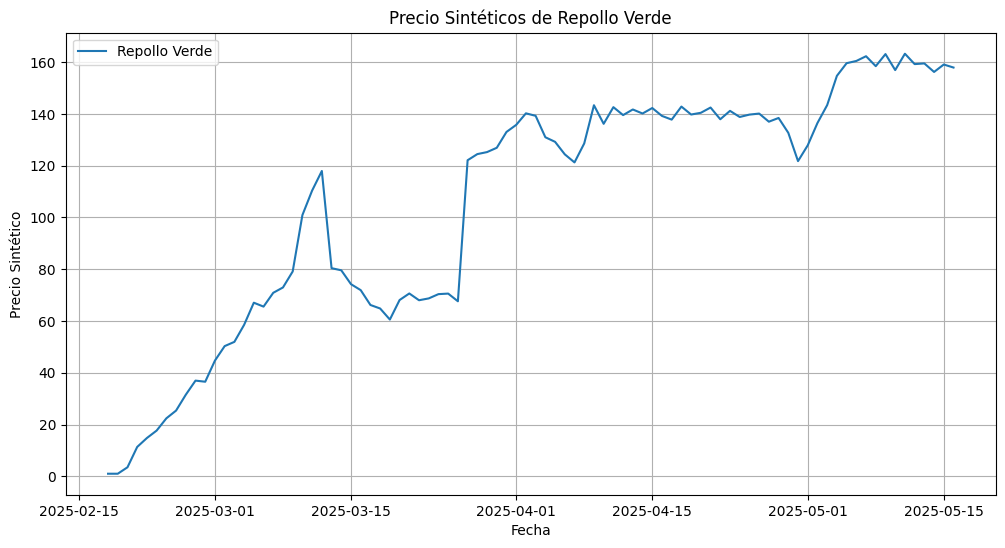

In [27]:

# Mostrrar una grafica de ejemplo
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
df_producto = df_sintetico_final[df_sintetico_final['PRODUCTO'] == productos[0]]
plt.plot(df_producto['FECHA'], df_producto['PRECIO_SINTETICO'], label=productos[0])
plt.title('Precio Sintéticos de '+ productos[0])
plt.xlabel('Fecha')
plt.ylabel('Precio Sintético')
plt.legend()
plt.grid()
plt.show()

# Prophet para la prediccion de historicos

## Prediccion de precios para 7 dias

In [9]:
from prophet import Prophet
import pandas as pd
import numpy as np



resultados_pred = []

for producto in df_sintetico_final['PRODUCTO'].unique():
    df_producto = df_sintetico_final[df_sintetico_final['PRODUCTO'] == producto].copy()
    df_producto = df_producto.dropna(subset=['PRECIO_SINTETICO', 'FECHA'])
    if len(df_producto) < 5:  # si hay pocos datos, salta
        continue

    # Prophet requiere columnas 'ds' y 'y'
    df_producto = df_producto.groupby('FECHA', as_index=False)['PRECIO_SINTETICO'].mean()
    df_producto.rename(columns={'FECHA': 'ds', 'PRECIO_SINTETICO': 'y'}, inplace=True)

    model = Prophet(daily_seasonality=True)
    model.fit(df_producto)

    # Crear dataframe futuro para 7 días
    future = model.make_future_dataframe(periods=7)

    forecast = model.predict(future)

    # Extraer fechas y predicción
    df_forecast = forecast[['ds', 'yhat']].tail(7)
    df_forecast['PRODUCTO'] = producto

    # Para mantener el formato
    df_forecast.rename(columns={'ds': 'FECHA', 'yhat': 'PRECIO_PREDICTO'}, inplace=True)

    resultados_pred.append(df_forecast)

df_pred_final = pd.concat(resultados_pred, ignore_index=True)

print(df_pred_final.head())


c:\Users\SANTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
14:47:59 - cmdstanpy - INFO - Chain [1] start processing
14:48:00 - cmdstanpy - INFO - Chain [1] done processing
14:48:00 - cmdstanpy - INFO - Chain [1] start processing
14:48:00 - cmdstanpy - INFO - Chain [1] done processing
14:48:01 - cmdstanpy - INFO - Chain [1] start processing
14:48:01 - cmdstanpy - INFO - Chain [1] done processing
14:48:01 - cmdstanpy - INFO - Chain [1] start processing
14:48:02 - cmdstanpy - INFO - Chain [1] done processing
14:48:02 - cmdstanpy - INFO - Chain [1] start processing
14:48:02 - cmdstanpy - INFO - Chain [1] done processing
14:48:02 - cmdstanpy - INFO - Chain [1] start processing
14:48:03 - cmdstanpy - INFO - Chain [1] done processing
14:48:03 - cmdstanpy - INFO - Chain [1] star

       FECHA  PRECIO_PREDICTO            PRODUCTO
0 2025-05-17        10.631536  Aguacate papelillo
1 2025-05-18         9.727919  Aguacate papelillo
2 2025-05-19        10.889715  Aguacate papelillo
3 2025-05-20         9.891556  Aguacate papelillo
4 2025-05-21        10.556087  Aguacate papelillo


In [10]:
df_pred_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   FECHA            434 non-null    datetime64[ns]
 1   PRECIO_PREDICTO  434 non-null    float64       
 2   PRODUCTO         434 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 10.3+ KB


In [11]:
df_sintetico_final.sort_values('FECHA', inplace=True)
df_sintetico_final.iloc[-1]


FECHA               2025-05-16 00:00:00
PRODUCTO                      Zanahoria
PRECIO_SINTETICO                  81.01
CANTIDAD                  Bulto - 50 Kg
Name: 4959, dtype: object

In [12]:
df_pred_final.sort_values('FECHA', inplace=True)
df_pred_final.iloc[0]

FECHA              2025-05-17 00:00:00
PRECIO_PREDICTO              10.631536
PRODUCTO            Aguacate papelillo
Name: 0, dtype: object

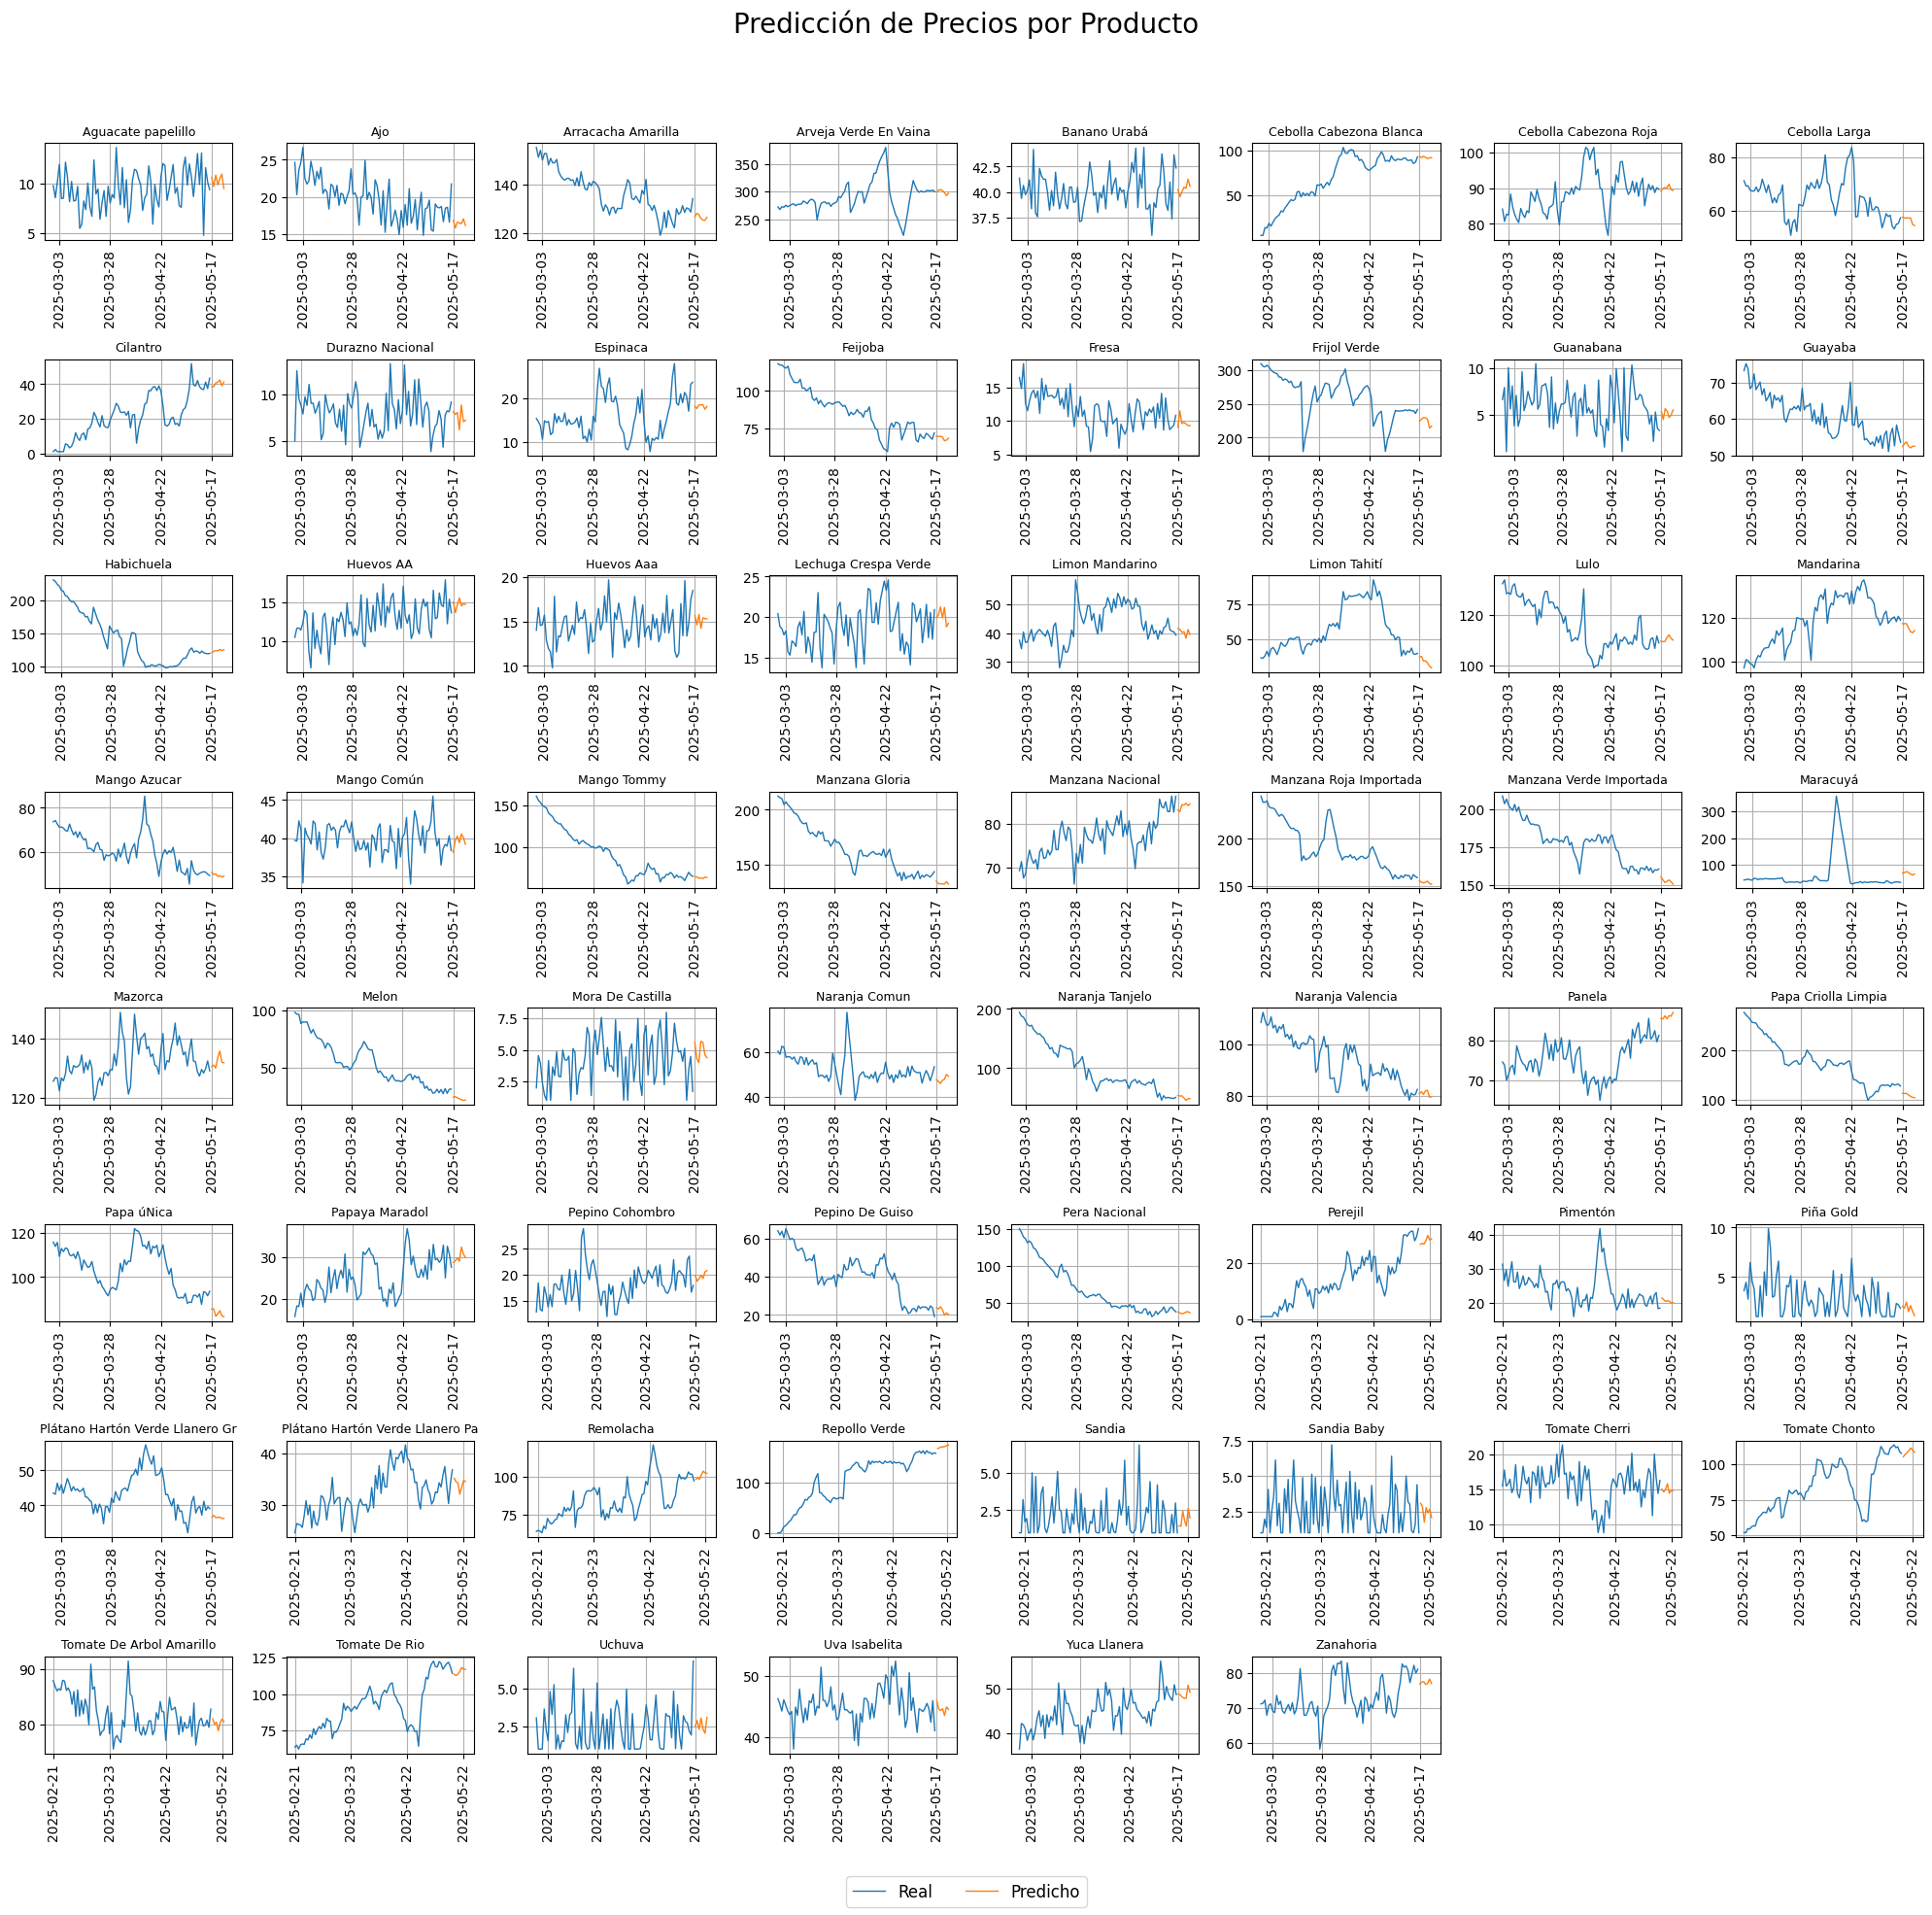

In [13]:
import matplotlib.pyplot as plt
import numpy as np

productos = df_all['PRODUCTO'].unique()
num_productos = len(productos)
plots_por_figura = 64  # 8x8
filas, columnas = 8, 8

for i in range(0, num_productos, plots_por_figura):
    fig, axes = plt.subplots(filas, columnas, figsize=(20, 20))
    fig.suptitle('Predicción de Precios por Producto', fontsize=20)
    axes = axes.flatten()

    for j, producto in enumerate(productos[i:i + plots_por_figura]):
        ax = axes[j]
        df_grouped = df_sintetico_final[df_sintetico_final['PRODUCTO'] == producto].copy()
        df_pred_grouped = df_pred_final[df_pred_final['PRODUCTO'] == producto].copy()

        df_grouped = df_grouped.sort_values('FECHA')
        df_pred_grouped = df_pred_grouped.sort_values('FECHA')

        ax.plot(df_grouped['FECHA'], df_grouped['PRECIO_SINTETICO'], label='Real', linewidth=1)
        ax.plot(df_pred_grouped['FECHA'], df_pred_grouped['PRECIO_PREDICTO'], label='Predicho', linewidth=1)
        ax.set_title(producto, fontsize=9)
        ax.tick_params(axis='x', labelrotation=90)
        ax.grid(True)
        
        # Opcional: reducir cantidad de ticks para claridad
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))

    # Desactivar subplots sobrantes si no se usan todos
    for k in range(j + 1, plots_por_figura):
        fig.delaxes(axes[k])

    # Agregar leyenda general
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



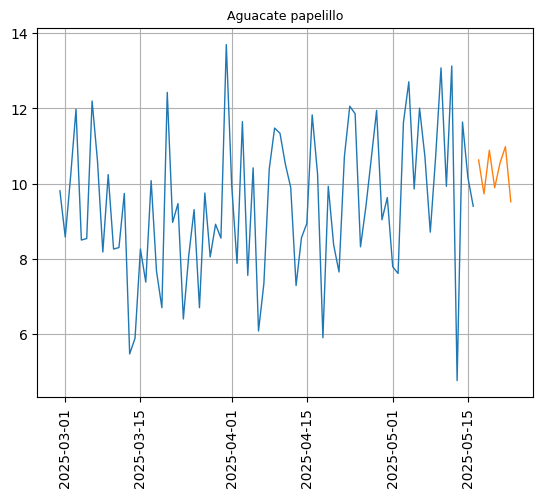

In [35]:
productos = df_all['PRODUCTO'].unique()
df_grouped = df_sintetico_final[df_sintetico_final['PRODUCTO'] == productos[0]].copy()
df_pred_grouped = df_pred_final[df_pred_final['PRODUCTO'] == productos[0]].copy()

df_grouped = df_grouped.sort_values('FECHA')
df_pred_grouped = df_pred_grouped.sort_values('FECHA')

plt.plot(df_grouped['FECHA'], df_grouped['PRECIO_SINTETICO'], label='Real', linewidth=1)
plt.plot(df_pred_grouped['FECHA'], df_pred_grouped['PRECIO_PREDICTO'], label='Predicho', linewidth=1)
plt.title(productos[0], fontsize=9)
plt.tick_params(axis='x', labelrotation=90)
plt.grid(True)

In [14]:
df_pred_final.to_csv('../Datos_Precios/precios_cantidad_predichos_prophet.csv', index=False)

